In [0]:
from collections import defaultdict

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.externals.joblib import Parallel, delayed
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array


In [0]:
def get_max_value_key(dic):
    """Gets the key for the maximum value in a dict."""
    v = np.array(list(dic.values()))
    k = np.array(list(dic.keys()))

    maxima = np.where(v == np.max(v))[0]
    if len(maxima) == 1:
        return k[maxima[0]]
    else:
        # In order to be consistent, always selects the minimum key
        # (guaranteed to be unique) when there are multiple maximum values.
        return k[maxima[np.argmin(k[maxima])]]


def encode_features(X, enc_map=None):
    """Converts categorical values in each column of X to integers in the range
    [0, n_unique_values_in_column - 1], if X is not already of integer type.
    If mapping is not provided, it is calculated based on the values in X.
    Unknown values during prediction get a value of -1. np.NaNs are ignored
    during encoding, and get treated as unknowns during prediction.
    """
    if np.issubdtype(X.dtype, np.integer):
        # Already integer type, so we can take a shortcut. Simply reshape
        # the data to mapping dictionaries, and do nothing with X.
        enc_map = [{val: val for val in np.unique(col)} for col in X.T]
        return X, enc_map

    if enc_map is None:
        fit = True
        # We will calculate enc_map, so initialize the list of column mappings.
        enc_map = []
    else:
        fit = False

    Xenc = np.zeros(X.shape).astype('int')
    for ii in range(X.shape[1]):
        if fit:
            col_enc = {val: jj for jj, val in enumerate(np.unique(X[:, ii]))
                       if not (isinstance(val, float) and np.isnan(val))}
            enc_map.append(col_enc)
        # Unknown categories (including np.NaNs) all get a value of -1.
        Xenc[:, ii] = np.array([enc_map[ii].get(x, -1) for x in X[:, ii]])

    return Xenc, enc_map


def decode_centroids(encoded, mapping):
    """Decodes the encoded centroids array back to the original data
    labels using a list of mappings.
    """
    decoded = []
    for ii in range(encoded.shape[1]):
        # Invert the mapping so that we can decode.
        inv_mapping = {v: k for k, v in mapping[ii].items()}
        decoded.append(np.vectorize(inv_mapping.__getitem__)(encoded[:, ii]))
    return np.atleast_2d(np.array(decoded)).T


def get_unique_rows(a):
    """Gets the unique rows in a numpy array."""
    return np.vstack({tuple(row) for row in a})
  
def matching_dissim(a, b, **_):
  """Simple matching dissimilarity function"""
  return np.sum(a != b, axis=1)


def euclidean_dissim(a, b, **_):
    """Euclidean distance dissimilarity function"""
    if np.isnan(a).any() or np.isnan(b).any():
        raise ValueError("Missing values detected in numerical columns.")
    return np.sum((a - b) ** 2, axis=1)


def ng_dissim(a, b, X=None, membship=None):
    """Ng et al.'s dissimilarity measure, as presented in
    Michael K. Ng, Mark Junjie Li, Joshua Zhexue Huang, and Zengyou He, "On the
    Impact of Dissimilarity Measure in k-Modes Clustering Algorithm", IEEE
    Transactions on Pattern Analysis and Machine Intelligence, Vol. 29, No. 3,
    January, 2007
    This function can potentially speed up training convergence.
    Note that membship must be a rectangular array such that the
    len(membship) = len(a) and len(membship[i]) = X.shape[1]
    In case of missing membship, this function reverts back to
    matching dissimilarity (e.g., when predicting).
    """
    # Without membership, revert to matching dissimilarity
    if membship is None:
        return matching_dissim(a, b)

    def calc_cjr(b, X, memj, idr):
        """Num objects w/ category value x_{i,r} for rth attr in jth cluster"""
        xcids = np.where(memj == 1)
        return float((np.take(X, xcids, axis=0)[0][:, idr] == b[idr]).sum(0))

    def calc_dissim(b, X, memj, idr):
        # Size of jth cluster
        cj = float(np.sum(memj))
        return (1.0 - (calc_cjr(b, X, memj, idr) / cj)) if cj != 0.0 else 0.0

    if len(membship) != a.shape[0] and len(membship[0]) != X.shape[1]:
        raise ValueError("'membship' must be a rectangular array where "
                         "the number of rows in 'membship' equals the "
                         "number of rows in 'a' and the number of "
                         "columns in 'membship' equals the number of rows in 'X'.")

    return np.array([np.array([calc_dissim(b, X, membship[idj], idr)
                               if b[idr] == t else 1.0
                               for idr, t in enumerate(val_a)]).sum(0)
                     for idj, val_a in enumerate(a)])

In [0]:
def init_huang(X, n_clusters, dissim, random_state):
    """Initialize centroids according to method by Huang [1997]."""
    n_attrs = X.shape[1]
    centroids = np.empty((n_clusters, n_attrs), dtype='object')
    # determine frequencies of attributes
    for iattr in range(n_attrs):
        freq = defaultdict(int)
        for curattr in X[:, iattr]:
            freq[curattr] += 1
        # Sample centroids using the probabilities of attributes.
        # (I assume that's what's meant in the Huang [1998] paper; it works,
        # at least)
        # Note: sampling using population in static list with as many choices
        # as frequency counts. Since the counts are small integers,
        # memory consumption is low.
        choices = [chc for chc, wght in freq.items() for _ in range(wght)]
        # So that we are consistent between Python versions,
        # each with different dict ordering.
        choices = sorted(choices)
        centroids[:, iattr] = random_state.choice(choices, n_clusters)
    # The previously chosen centroids could result in empty clusters,
    # so set centroid to closest point in X.
    for ik in range(n_clusters):
        ndx = np.argsort(dissim(X, centroids[ik]))
        # We want the centroid to be unique, if possible.
        while np.all(X[ndx[0]] == centroids, axis=1).any() and ndx.shape[0] > 1:
            ndx = np.delete(ndx, 0)
        centroids[ik] = X[ndx[0]]

    return centroids


def init_cao(X, n_clusters, dissim):
    """Initialize centroids according to method by Cao et al. [2009].
    Note: O(N * attr * n_clusters**2), so watch out with large n_clusters
    """
    n_points, n_attrs = X.shape
    centroids = np.empty((n_clusters, n_attrs), dtype='object')
    # Method is based on determining density of points.
    dens = np.zeros(n_points)
    for iattr in range(n_attrs):
        freq = defaultdict(int)
        for val in X[:, iattr]:
            freq[val] += 1
        for ipoint in range(n_points):
            dens[ipoint] += freq[X[ipoint, iattr]] / float(n_points) / float(n_attrs)

    # Choose initial centroids based on distance and density.
    centroids[0] = X[np.argmax(dens)]
    if n_clusters > 1:
        # For the remaining centroids, choose maximum dens * dissim to the
        # (already assigned) centroid with the lowest dens * dissim.
        for ik in range(1, n_clusters):
            dd = np.empty((ik, n_points))
            for ikk in range(ik):
                dd[ikk] = dissim(X, centroids[ikk]) * dens
            centroids[ik] = X[np.argmax(np.min(dd, axis=0))]

    return centroids


def move_point_cat(point, ipoint, to_clust, from_clust, cl_attr_freq,
                   membship, centroids):
    """Move point between clusters, categorical attributes."""
    membship[to_clust, ipoint] = 1
    membship[from_clust, ipoint] = 0
    # Update frequencies of attributes in cluster.
    for iattr, curattr in enumerate(point):
        to_attr_counts = cl_attr_freq[to_clust][iattr]
        from_attr_counts = cl_attr_freq[from_clust][iattr]

        # Increment the attribute count for the new "to" cluster
        to_attr_counts[curattr] += 1

        current_attribute_value_freq = to_attr_counts[curattr]
        current_centroid_value = centroids[to_clust][iattr]
        current_centroid_freq = to_attr_counts[current_centroid_value]
        if current_centroid_freq < current_attribute_value_freq:
            # We have incremented this value to the new mode. Update the centroid.
            centroids[to_clust][iattr] = curattr

        # Decrement the attribute count for the old "from" cluster
        from_attr_counts[curattr] -= 1

        old_centroid_value = centroids[from_clust][iattr]
        if old_centroid_value == curattr:
            # We have just removed a count from the old centroid value. We need to
            # recalculate the centroid as it may no longer be the maximum
            centroids[from_clust][iattr] = get_max_value_key(from_attr_counts)

    return cl_attr_freq, membship, centroids


def _labels_cost(X, centroids, dissim, membship=None):
    """Calculate labels and cost function given a matrix of points and
    a list of centroids for the k-modes algorithm.
    """

    X = check_array(X)

    n_points = X.shape[0]
    cost = 0.
    labels = np.empty(n_points, dtype=np.uint16)
    for ipoint, curpoint in enumerate(X):
        diss = dissim(centroids, curpoint, X=X, membship=membship)
        clust = np.argmin(diss)
        labels[ipoint] = clust
        cost += diss[clust]

    return labels, cost


def _k_modes_iter(X, centroids, cl_attr_freq, membship, dissim, random_state):
    """Single iteration of k-modes clustering algorithm"""
    moves = 0
    for ipoint, curpoint in enumerate(X):
        clust = np.argmin(dissim(centroids, curpoint, X=X, membship=membship))
        if membship[clust, ipoint]:
            # Point is already in its right place.
            continue

        # Move point, and update old/new cluster frequencies and centroids.
        moves += 1
        old_clust = np.argwhere(membship[:, ipoint])[0][0]

        cl_attr_freq, membship, centroids = move_point_cat(
            curpoint, ipoint, clust, old_clust, cl_attr_freq, membship, centroids
        )

        # In case of an empty cluster, reinitialize with a random point
        # from the largest cluster.
        if not membship[old_clust, :].any():
            from_clust = membship.sum(axis=1).argmax()
            choices = [ii for ii, ch in enumerate(membship[from_clust, :]) if ch]
            rindx = random_state.choice(choices)

            cl_attr_freq, membship, centroids = move_point_cat(
                X[rindx], rindx, old_clust, from_clust, cl_attr_freq, membship, centroids
            )

    return centroids, moves


def k_modes_single(X, n_clusters, n_points, n_attrs, max_iter, dissim, init, init_no,
                   verbose, random_state):
    random_state = check_random_state(random_state)
    # _____ INIT _____
    if verbose:
        print("Init: initializing centroids")
    if isinstance(init, str) and init.lower() == 'huang':
        centroids = init_huang(X, n_clusters, dissim, random_state)
    elif isinstance(init, str) and init.lower() == 'cao':
        centroids = init_cao(X, n_clusters, dissim)
    elif isinstance(init, str) and init.lower() == 'random':
        seeds = random_state.choice(range(n_points), n_clusters)
        centroids = X[seeds]
    elif hasattr(init, '__array__'):
        # Make sure init is a 2D array.
        if len(init.shape) == 1:
            init = np.atleast_2d(init).T
        assert init.shape[0] == n_clusters, \
            "Wrong number of initial centroids in init ({}, should be {})." \
                .format(init.shape[0], n_clusters)
        assert init.shape[1] == n_attrs, \
            "Wrong number of attributes in init ({}, should be {})." \
                .format(init.shape[1], n_attrs)
        centroids = np.asarray(init, dtype=np.uint16)
    else:
        raise NotImplementedError

    if verbose:
        print("Init: initializing clusters")
    membship = np.zeros((n_clusters, n_points), dtype=np.uint8)
    # cl_attr_freq is a list of lists with dictionaries that contain the
    # frequencies of values per cluster and attribute.
    cl_attr_freq = [[defaultdict(int) for _ in range(n_attrs)]
                    for _ in range(n_clusters)]
    for ipoint, curpoint in enumerate(X):
        # Initial assignment to clusters
        clust = np.argmin(dissim(centroids, curpoint, X=X, membship=membship))
        membship[clust, ipoint] = 1
        # Count attribute values per cluster.
        for iattr, curattr in enumerate(curpoint):
            cl_attr_freq[clust][iattr][curattr] += 1
    # Perform an initial centroid update.
    for ik in range(n_clusters):
        for iattr in range(n_attrs):
            if sum(membship[ik]) == 0:
                # Empty centroid, choose randomly
                centroids[ik, iattr] = random_state.choice(X[:, iattr])
            else:
                centroids[ik, iattr] = get_max_value_key(cl_attr_freq[ik][iattr])

    # _____ ITERATION _____
    if verbose:
        print("Starting iterations...")
    itr = 0
    labels = None
    converged = False
    cost = np.Inf
    while itr <= max_iter and not converged:
        itr += 1
        centroids, moves = _k_modes_iter(X, centroids, cl_attr_freq, membship, dissim, random_state)
        # All points seen in this iteration
        labels, ncost = _labels_cost(X, centroids, dissim, membship)
        converged = (moves == 0) or (ncost >= cost)
        cost = ncost
        if verbose:
            print("Run {}, iteration: {}/{}, moves: {}, cost: {}"
                  .format(init_no + 1, itr, max_iter, moves, cost))

    return centroids, labels, cost, itr


def k_modes(X, n_clusters, max_iter, dissim, init, n_init, verbose, random_state, n_jobs):
    """k-modes algorithm"""
    random_state = check_random_state(random_state)
    if sparse.issparse(X):
        raise TypeError("k-modes does not support sparse data.")

    # Convert pandas objects to numpy arrays.
    if 'pandas' in str(X.__class__):
        X = X.values

    X = check_array(X, dtype=None)

    # Convert the categorical values in X to integers for speed.
    # Based on the unique values in X, we can make a mapping to achieve this.
    X, enc_map = encode_features(X)

    n_points, n_attrs = X.shape
    assert n_clusters <= n_points, "Cannot have more clusters ({}) " \
                                   "than data points ({}).".format(n_clusters, n_points)

    # Are there more n_clusters than unique rows? Then set the unique
    # rows as initial values and skip iteration.
    unique = get_unique_rows(X)
    n_unique = unique.shape[0]
    if n_unique <= n_clusters:
        max_iter = 0
        n_init = 1
        n_clusters = n_unique
        init = unique

    results = []
    seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
    if n_jobs == 1:
        for init_no in range(n_init):
            results.append(k_modes_single(X, n_clusters, n_points, n_attrs, max_iter,
                                          dissim, init, init_no, verbose, seeds[init_no]))
    else:
        results = Parallel(n_jobs=n_jobs, verbose=0)(
            delayed(k_modes_single)(X, n_clusters, n_points, n_attrs, max_iter,
                                    dissim, init, init_no, verbose, seed)
            for init_no, seed in enumerate(seeds))
    all_centroids, all_labels, all_costs, all_n_iters = zip(*results)

    best = np.argmin(all_costs)
    if n_init > 1 and verbose:
        print("Best run was number {}".format(best + 1))

    return all_centroids[best], enc_map, all_labels[best], \
        all_costs[best], all_n_iters[best]



In [0]:
class KModes(BaseEstimator, ClusterMixin):

    """k-modes clustering algorithm for categorical data.
    Parameters
    -----------
    n_clusters : int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.
    max_iter : int, default: 300
        Maximum number of iterations of the k-modes algorithm for a
        single run.
    cat_dissim : func, default: matching_dissim
        Dissimilarity function used by the k-modes algorithm for categorical variables.
        Defaults to the matching dissimilarity function.
    init : {'Huang', 'Cao', 'random' or an ndarray}, default: 'Cao'
        Method for initialization:
        'Huang': Method in Huang [1997, 1998]
        'Cao': Method in Cao et al. [2009]
        'random': choose 'n_clusters' observations (rows) at random from
        data for the initial centroids.
        If an ndarray is passed, it should be of shape (n_clusters, n_features)
        and gives the initial centroids.
    n_init : int, default: 10
        Number of time the k-modes algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of cost.
    verbose : int, optional
        Verbosity mode.
    random_state : int, RandomState instance or None, optional, default: None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    n_jobs : int, default: 1
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For n_jobs below -1,
        (n_cpus + 1 + n_jobs) are used. Thus for n_jobs = -2, all CPUs but one
        are used.
    Attributes
    ----------
    cluster_centroids_ : array, [n_clusters, n_features]
        Categories of cluster centroids
    labels_ :
        Labels of each point
    cost_ : float
        Clustering cost, defined as the sum distance of all points to
        their respective cluster centroids.
    n_iter_ : int
        The number of iterations the algorithm ran for.
    Notes
    -----
    See:
    Huang, Z.: Extensions to the k-modes algorithm for clustering large
    data sets with categorical values, Data Mining and Knowledge
    Discovery 2(3), 1998.
    """

    def __init__(self, n_clusters=8, max_iter=100, cat_dissim=matching_dissim,
                 init='Cao', n_init=1, verbose=0, random_state=None, n_jobs=1):

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.cat_dissim = cat_dissim
        self.init = init
        self.n_init = n_init
        self.verbose = verbose
        self.random_state = random_state
        self.n_jobs = n_jobs
        if ((isinstance(self.init, str) and self.init == 'Cao') or
                hasattr(self.init, '__array__')) and self.n_init > 1:
            if self.verbose:
                print("Initialization method and algorithm are deterministic. "
                      "Setting n_init to 1.")
            self.n_init = 1

    def fit(self, X, y=None, **kwargs):
        """Compute k-modes clustering.
        Parameters
        ----------
        X : array-like, shape=[n_samples, n_features]
        """

        random_state = check_random_state(self.random_state)
        self._enc_cluster_centroids, self._enc_map, self.labels_,\
            self.cost_, self.n_iter_ = k_modes(X,
                                               self.n_clusters,
                                               self.max_iter,
                                               self.cat_dissim,
                                               self.init,
                                               self.n_init,
                                               self.verbose,
                                               random_state,
                                               self.n_jobs)
        return self

    def fit_predict(self, X, y=None, **kwargs):
        """Compute cluster centroids and predict cluster index for each sample.
        Convenience method; equivalent to calling fit(X) followed by
        predict(X).
        """
        return self.fit(X, **kwargs).predict(X, **kwargs)

    def predict(self, X, **kwargs):
        """Predict the closest cluster each sample in X belongs to.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            New data to predict.
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """
        assert hasattr(self, '_enc_cluster_centroids'), "Model not yet fitted."

        if self.verbose and self.cat_dissim == ng_dissim:
            print("Ng's dissimilarity measure was used to train this model, "
                  "but now that it is predicting the model will fall back to "
                  "using simple matching dissimilarity.")

        X = check_array(X, dtype=None)
        X, _ = encode_features(X, enc_map=self._enc_map)
        return _labels_cost(X, self._enc_cluster_centroids, self.cat_dissim)[0]

    @property
    def cluster_centroids_(self):
        if hasattr(self, '_enc_cluster_centroids'):
            return decode_centroids(self._enc_cluster_centroids, self._enc_map)
        else:
            raise AttributeError("'{}' object has no attribute 'cluster_centroids_' "
                                 "because the model is not yet fitted.")

In [0]:
# Number of tries we give the initialization methods to find non-empty
# clusters before we switch to random initialization.
MAX_INIT_TRIES = 20
# Number of tries we give the initialization before we raise an
# initialization error.
RAISE_INIT_TRIES = 100


def move_point_num(point, to_clust, from_clust, cl_attr_sum, cl_memb_sum):
    """Move point between clusters, numerical attributes."""
    # Update sum of attributes in cluster.
    for iattr, curattr in enumerate(point):
        cl_attr_sum[to_clust][iattr] += curattr
        cl_attr_sum[from_clust][iattr] -= curattr
    # Update sums of memberships in cluster
    cl_memb_sum[to_clust] += 1
    cl_memb_sum[from_clust] -= 1
    return cl_attr_sum, cl_memb_sum


def _split_num_cat(X, categorical):
    """Extract numerical and categorical columns.
    Convert to numpy arrays, if needed.
    :param X: Feature matrix
    :param categorical: Indices of categorical columns
    """
    Xnum = np.asanyarray(X[:, [ii for ii in range(X.shape[1])
                               if ii not in categorical]]).astype(np.float64)
    Xcat = np.asanyarray(X[:, categorical])
    return Xnum, Xcat


def _labels_cost(Xnum, Xcat, centroids, num_dissim, cat_dissim, gamma, membship=None):
    """Calculate labels and cost function given a matrix of points and
    a list of centroids for the k-prototypes algorithm.
    """

    n_points = Xnum.shape[0]
    Xnum = check_array(Xnum)

    cost = 0.
    labels = np.empty(n_points, dtype=np.uint16)
    for ipoint in range(n_points):
        # Numerical cost = sum of Euclidean distances
        num_costs = num_dissim(centroids[0], Xnum[ipoint])
        cat_costs = cat_dissim(centroids[1], Xcat[ipoint], X=Xcat, membship=membship)
        # Gamma relates the categorical cost to the numerical cost.
        tot_costs = num_costs + gamma * cat_costs
        clust = np.argmin(tot_costs)
        labels[ipoint] = clust
        cost += tot_costs[clust]

    return labels, cost


def _k_prototypes_iter(Xnum, Xcat, centroids, cl_attr_sum, cl_memb_sum, cl_attr_freq,
                       membship, num_dissim, cat_dissim, gamma, random_state):
    """Single iteration of the k-prototypes algorithm"""
    moves = 0
    for ipoint in range(Xnum.shape[0]):
        clust = np.argmin(
            num_dissim(centroids[0], Xnum[ipoint]) +
            gamma * cat_dissim(centroids[1], Xcat[ipoint], X=Xcat, membship=membship)
        )
        if membship[clust, ipoint]:
            # Point is already in its right place.
            continue

        # Move point, and update old/new cluster frequencies and centroids.
        moves += 1
        old_clust = np.argwhere(membship[:, ipoint])[0][0]

        # Note that membship gets updated by move_point_cat.
        # move_point_num only updates things specific to the k-means part.
        cl_attr_sum, cl_memb_sum = move_point_num(
            Xnum[ipoint], clust, old_clust, cl_attr_sum, cl_memb_sum
        )
        cl_attr_freq, membship, centroids[1] = move_point_cat(
            Xcat[ipoint], ipoint, clust, old_clust,
            cl_attr_freq, membship, centroids[1]
        )

        # Update old and new centroids for numerical attributes using
        # the means and sums of all values
        for iattr in range(len(Xnum[ipoint])):
            for curc in (clust, old_clust):
                if cl_memb_sum[curc]:
                    centroids[0][curc, iattr] = cl_attr_sum[curc, iattr] / cl_memb_sum[curc]
                else:
                    centroids[0][curc, iattr] = 0.

        # In case of an empty cluster, reinitialize with a random point
        # from largest cluster.
        if not cl_memb_sum[old_clust]:
            from_clust = membship.sum(axis=1).argmax()
            choices = [ii for ii, ch in enumerate(membship[from_clust, :]) if ch]
            rindx = random_state.choice(choices)

            cl_attr_sum, cl_memb_sum = move_point_num(
                Xnum[rindx], old_clust, from_clust, cl_attr_sum, cl_memb_sum
            )
            cl_attr_freq, membship, centroids[1] = move_point_cat(
                Xcat[rindx], rindx, old_clust, from_clust,
                cl_attr_freq, membship, centroids[1]
            )

    return centroids, moves


def k_prototypes_single(Xnum, Xcat, nnumattrs, ncatattrs, n_clusters, n_points,
                        max_iter, num_dissim, cat_dissim, gamma, init, init_no,
                        verbose, random_state):
    # For numerical part of initialization, we don't have a guarantee
    # that there is not an empty cluster, so we need to retry until
    # there is none.
    random_state = check_random_state(random_state)
    init_tries = 0
    while True:
        init_tries += 1
        # _____ INIT _____
        if verbose:
            print("Init: initializing centroids")
        if isinstance(init, str) and init.lower() == 'huang':
            centroids = init_huang(Xcat, n_clusters, cat_dissim, random_state)
        elif isinstance(init, str) and init.lower() == 'cao':
            centroids = init_cao(Xcat, n_clusters, cat_dissim)
        elif isinstance(init, str) and init.lower() == 'random':
            seeds = random_state.choice(range(n_points), n_clusters)
            centroids = Xcat[seeds]
        elif isinstance(init, list):
            # Make sure inits are 2D arrays.
            init = [np.atleast_2d(cur_init).T if len(cur_init.shape) == 1
                    else cur_init
                    for cur_init in init]
            assert init[0].shape[0] == n_clusters, \
                "Wrong number of initial numerical centroids in init " \
                "({}, should be {}).".format(init[0].shape[0], n_clusters)
            assert init[0].shape[1] == nnumattrs, \
                "Wrong number of numerical attributes in init ({}, should be {})." \
                    .format(init[0].shape[1], nnumattrs)
            assert init[1].shape[0] == n_clusters, \
                "Wrong number of initial categorical centroids in init ({}, " \
                "should be {}).".format(init[1].shape[0], n_clusters)
            assert init[1].shape[1] == ncatattrs, \
                "Wrong number of categorical attributes in init ({}, should be {})." \
                    .format(init[1].shape[1], ncatattrs)
            centroids = [np.asarray(init[0], dtype=np.float64),
                         np.asarray(init[1], dtype=np.uint16)]
        else:
            raise NotImplementedError("Initialization method not supported.")

        if not isinstance(init, list):
            # Numerical is initialized by drawing from normal distribution,
            # categorical following the k-modes methods.
            meanx = np.mean(Xnum, axis=0)
            stdx = np.std(Xnum, axis=0)
            centroids = [
                meanx + random_state.randn(n_clusters, nnumattrs) * stdx,
                centroids
            ]

        if verbose:
            print("Init: initializing clusters")
        membship = np.zeros((n_clusters, n_points), dtype=np.uint8)
        # Keep track of the sum of attribute values per cluster so that we
        # can do k-means on the numerical attributes.
        cl_attr_sum = np.zeros((n_clusters, nnumattrs), dtype=np.float64)
        # Same for the membership sum per cluster
        cl_memb_sum = np.zeros(n_clusters, dtype=int)
        # cl_attr_freq is a list of lists with dictionaries that contain
        # the frequencies of values per cluster and attribute.
        cl_attr_freq = [[defaultdict(int) for _ in range(ncatattrs)]
                        for _ in range(n_clusters)]
        for ipoint in range(n_points):
            # Initial assignment to clusters
            clust = np.argmin(
                num_dissim(centroids[0], Xnum[ipoint]) + gamma *
                cat_dissim(centroids[1], Xcat[ipoint], X=Xcat, membship=membship)
            )
            membship[clust, ipoint] = 1
            cl_memb_sum[clust] += 1
            # Count attribute values per cluster.
            for iattr, curattr in enumerate(Xnum[ipoint]):
                cl_attr_sum[clust, iattr] += curattr
            for iattr, curattr in enumerate(Xcat[ipoint]):
                cl_attr_freq[clust][iattr][curattr] += 1

        # If no empty clusters, then consider initialization finalized.
        if membship.sum(axis=1).min() > 0:
            break

        if init_tries == MAX_INIT_TRIES:
            # Could not get rid of empty clusters. Randomly
            # initialize instead.
            init = 'random'
        elif init_tries == RAISE_INIT_TRIES:
            raise ValueError(
                "Clustering algorithm could not initialize. "
                "Consider assigning the initial clusters manually."
            )

    # Perform an initial centroid update.
    for ik in range(n_clusters):
        for iattr in range(nnumattrs):
            centroids[0][ik, iattr] = cl_attr_sum[ik, iattr] / cl_memb_sum[ik]
        for iattr in range(ncatattrs):
            centroids[1][ik, iattr] = get_max_value_key(cl_attr_freq[ik][iattr])

    # _____ ITERATION _____
    if verbose:
        print("Starting iterations...")
    itr = 0
    labels = None
    converged = False
    cost = np.Inf
    while itr <= max_iter and not converged:
        itr += 1
        centroids, moves = _k_prototypes_iter(Xnum, Xcat, centroids,
                                              cl_attr_sum, cl_memb_sum, cl_attr_freq,
                                              membship, num_dissim, cat_dissim, gamma,
                                              random_state)

        # All points seen in this iteration
        labels, ncost = _labels_cost(Xnum, Xcat, centroids,
                                     num_dissim, cat_dissim, gamma, membship)
        converged = (moves == 0) or (ncost >= cost)
        cost = ncost
        if verbose:
            print("Run: {}, iteration: {}/{}, moves: {}, ncost: {}"
                  .format(init_no + 1, itr, max_iter, moves, ncost))

    return centroids, labels, cost, itr


def k_prototypes(X, categorical, n_clusters, max_iter, num_dissim, cat_dissim,
                 gamma, init, n_init, verbose, random_state, n_jobs):
    """k-prototypes algorithm"""
    random_state = check_random_state(random_state)
    if sparse.issparse(X):
        raise TypeError("k-prototypes does not support sparse data.")

    # Convert pandas objects to numpy arrays.
    if 'pandas' in str(X.__class__):
        X = X.values

    if categorical is None or not categorical:
        raise NotImplementedError(
            "No categorical data selected, effectively doing k-means. "
            "Present a list of categorical columns, or use scikit-learn's "
            "KMeans instead."
        )
    if isinstance(categorical, int):
        categorical = [categorical]
    assert len(categorical) != X.shape[1], \
        "All columns are categorical, use k-modes instead of k-prototypes."
    assert max(categorical) < X.shape[1], \
        "Categorical index larger than number of columns."

    ncatattrs = len(categorical)
    nnumattrs = X.shape[1] - ncatattrs
    n_points = X.shape[0]
    assert n_clusters <= n_points, "Cannot have more clusters ({}) " \
                                   "than data points ({}).".format(n_clusters, n_points)

    Xnum, Xcat = _split_num_cat(X, categorical)
    Xnum, Xcat = check_array(Xnum), check_array(Xcat, dtype=None)

    # Convert the categorical values in Xcat to integers for speed.
    # Based on the unique values in Xcat, we can make a mapping to achieve this.
    Xcat, enc_map = encode_features(Xcat)

    # Are there more n_clusters than unique rows? Then set the unique
    # rows as initial values and skip iteration.
    unique = get_unique_rows(X)
    n_unique = unique.shape[0]
    if n_unique <= n_clusters:
        max_iter = 0
        n_init = 1
        n_clusters = n_unique
        init = list(_split_num_cat(unique, categorical))
        init[1], _ = encode_features(init[1], enc_map)

    # Estimate a good value for gamma, which determines the weighing of
    # categorical values in clusters (see Huang [1997]).
    if gamma is None:
        gamma = 0.5 * Xnum.std()

    results = []
    seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
    if n_jobs == 1:
        for init_no in range(n_init):
            results.append(k_prototypes_single(Xnum, Xcat, nnumattrs, ncatattrs,
                                               n_clusters, n_points, max_iter,
                                               num_dissim, cat_dissim, gamma,
                                               init, init_no, verbose, seeds[init_no]))
    else:
        results = Parallel(n_jobs=n_jobs, verbose=0)(
            delayed(k_prototypes_single)(Xnum, Xcat, nnumattrs, ncatattrs,
                                         n_clusters, n_points, max_iter,
                                         num_dissim, cat_dissim, gamma,
                                         init, init_no, verbose, seed)
            for init_no, seed in enumerate(seeds))
    all_centroids, all_labels, all_costs, all_n_iters = zip(*results)

    best = np.argmin(all_costs)
    if n_init > 1 and verbose:
        print("Best run was number {}".format(best + 1))

    # Note: return gamma in case it was automatically determined.
    return all_centroids[best], enc_map, all_labels[best], \
        all_costs[best], all_n_iters[best], gamma


In [0]:
class KPrototypes(KModes):
    """k-protoypes clustering algorithm for mixed numerical/categorical data.
    Parameters
    -----------
    n_clusters : int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.
    max_iter : int, default: 300
        Maximum number of iterations of the k-modes algorithm for a
        single run.
    num_dissim : func, default: euclidian_dissim
        Dissimilarity function used by the algorithm for numerical variables.
        Defaults to the Euclidian dissimilarity function.
    cat_dissim : func, default: matching_dissim
        Dissimilarity function used by the kmodes algorithm for categorical variables.
        Defaults to the matching dissimilarity function.
    n_init : int, default: 10
        Number of time the k-modes algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of cost.
    init : {'Huang', 'Cao', 'random' or a list of ndarrays}, default: 'Cao'
        Method for initialization:
        'Huang': Method in Huang [1997, 1998]
        'Cao': Method in Cao et al. [2009]
        'random': choose 'n_clusters' observations (rows) at random from
        data for the initial centroids.
        If a list of ndarrays is passed, it should be of length 2, with
        shapes (n_clusters, n_features) for numerical and categorical
        data respectively. These are the initial centroids.
    gamma : float, default: None
        Weighing factor that determines relative importance of numerical vs.
        categorical attributes (see discussion in Huang [1997]). By default,
        automatically calculated from data.
    verbose : integer, optional
        Verbosity mode.
    random_state : int, RandomState instance or None, optional, default: None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    n_jobs : int, default: 1
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For n_jobs below -1,
        (n_cpus + 1 + n_jobs) are used. Thus for n_jobs = -2, all CPUs but one
        are used.
    Attributes
    ----------
    cluster_centroids_ : array, [n_clusters, n_features]
        Categories of cluster centroids
    labels_ :
        Labels of each point
    cost_ : float
        Clustering cost, defined as the sum distance of all points to
        their respective cluster centroids.
    n_iter_ : int
        The number of iterations the algorithm ran for.
    gamma : float
        The (potentially calculated) weighing factor.
    Notes
    -----
    See:
    Huang, Z.: Extensions to the k-modes algorithm for clustering large
    data sets with categorical values, Data Mining and Knowledge
    Discovery 2(3), 1998.
    """

    def __init__(self, n_clusters=8, max_iter=100, num_dissim=euclidean_dissim,
                 cat_dissim=matching_dissim, init='Huang', n_init=10, gamma=None,
                 verbose=0, random_state=None, n_jobs=1):

        super(KPrototypes, self).__init__(n_clusters, max_iter, cat_dissim, init,
                                          verbose=verbose, random_state=random_state,
                                          n_jobs=n_jobs)
        self.num_dissim = num_dissim
        self.gamma = gamma
        self.n_init = n_init
        if isinstance(self.init, list) and self.n_init > 1:
            if self.verbose:
                print("Initialization method is deterministic. "
                      "Setting n_init to 1.")
            self.n_init = 1

    def fit(self, X, y=None, categorical=None):
        """Compute k-prototypes clustering.
        Parameters
        ----------
        X : array-like, shape=[n_samples, n_features]
        categorical : Index of columns that contain categorical data
        """

        random_state = check_random_state(self.random_state)
        # If self.gamma is None, gamma will be automatically determined from
        # the data. The function below returns its value.
        self._enc_cluster_centroids, self._enc_map, self.labels_, self.cost_,\
            self.n_iter_, self.gamma = k_prototypes(X,
                                                    categorical,
                                                    self.n_clusters,
                                                    self.max_iter,
                                                    self.num_dissim,
                                                    self.cat_dissim,
                                                    self.gamma,
                                                    self.init,
                                                    self.n_init,
                                                    self.verbose,
                                                    random_state,
                                                    self.n_jobs)
        return self

    def predict(self, X, categorical=None):
        """Predict the closest cluster each sample in X belongs to.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            New data to predict.
        categorical : Index of columns that contain categorical data
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """
        assert hasattr(self, '_enc_cluster_centroids'), "Model not yet fitted."

        Xnum, Xcat = _split_num_cat(X, categorical)
        Xnum, Xcat = check_array(Xnum), check_array(Xcat, dtype=None)
        Xcat, _ = encode_features(Xcat, enc_map=self._enc_map)
        return _labels_cost(Xnum, Xcat, self._enc_cluster_centroids,
                            self.num_dissim, self.cat_dissim, self.gamma)[0]

    @property
    def cluster_centroids_(self):
        if hasattr(self, '_enc_cluster_centroids'):
            return [
                self._enc_cluster_centroids[0],
                decode_centroids(self._enc_cluster_centroids[1], self._enc_map)
            ]
        else:
            raise AttributeError("'{}' object has no attribute 'cluster_centroids_' "
                                 "because the model is not yet fitted.")

##Colab initalization


In [25]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
^C
^C
^C


KeyboardInterrupt: ignored

In [15]:
!mkdir drive
!google-drive-ocamlfuse drive
!ls drive/"Colab Notebooks"

5291_Dataclean.ipynb	    “run_Gym_env.ipynb”的副本  Untitled2.ipynb
“GymRendering.ipynb”的副本  Untitled0.ipynb
Phasei_try.ipynb	    Untitled1.ipynb


##Run code

In [0]:
import pandas as pd
import numpy as np
from operator import methodcaller
data_num= pd.read_csv('drive/5291/feature_data_numeric_1.csv')
data_text=pd.read_csv('drive/5291/feature_data_text_1.csv')
data_result = pd.merge(data_num, data_text, on='msno', how='outer').dropna()
# feature_data_numeric_1.csv
df=data_result
del df['msno'] ;del df['artist_name1'] ;del df['artist_name2']

In [93]:
syms = np.unique(data_result.msno)
# np.genfromtxt(data_result, dtype=str, delimiter=',')[:, 0]
X = df.values
# genfromtxt(data_result, dtype=object, delimiter=',')[:, 1:]
X[:, 0] = X[:, 0].astype(float)

ncost=[]

for i in range(1,31):

  kproto = KPrototypes(n_clusters=i, init='Cao', verbose=2)
  clusters = kproto.fit_predict(X, categorical=[1, 2])

  # Print cluster centroids of the trained model.
  print(kproto.cluster_centroids_)
  # Print training statistics
  print(kproto.cost_)
  print(kproto.n_iter_)
  ncost.append(kproto.cost_)

for s, c in zip(syms, clusters):
    print("Symbol: {}, cluster:{}".format(s, c))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 20290866423102.6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 20290866423102.6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 20290866423102.6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 20290866423102.6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 20290866423102.6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 20290866423102.6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 20290866423102.6
Init: initializing c

ValueError: ignored

In [94]:
ncost

[20290866423102.6,
 6600561059253.87,
 2932944166945.8135,
 1847378677463.5872,
 1512499598468.356,
 1216515595118.1272,
 1140553380224.787,
 1011618394652.324,
 978661639805.9437,
 791011756858.0211,
 800630675695.3086,
 667090725397.5433,
 489834366064.19434,
 564113527694.0835,
 483046358633.03656,
 490238666507.8109,
 464855202128.11554,
 370931430706.44244,
 428102630138.4682,
 329561258133.41504,
 345742166985.89557,
 327982041315.9063,
 336911801047.9237]

In [96]:
len(ncost)

23

No handles with labels found to put in legend.


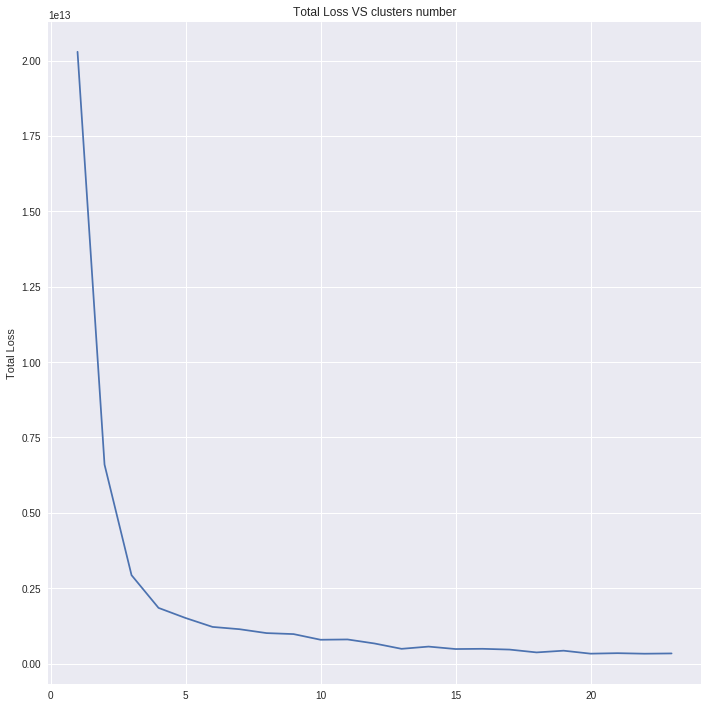

In [103]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
cluster=range(1,24)
ax.plot(cluster, ncost)
ax.set_title('Total Loss VS clusters number')
ax.legend(loc='upper left')
ax.set_ylabel('Total Loss')
# ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()

In [104]:
min(ncost)

327982041315.9063

In [108]:
np.argmin((ncost))

21

In [109]:
kproto = KPrototypes(n_clusters=21, init='Cao', verbose=2)
clusters = kproto.fit_predict(X, categorical=[1, 2])

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

In [0]:
Cluster_df=pd.DataFrame({'msno':syms, 'cluster_id':clusters})

In [0]:
# data_result = pd.merge(data_num, data_text, on='msno', how='outer').dropna()
# syms=(np.unique(data_result['msno']))

In [0]:
Cluster_df.to_csv("drive/5291/K-prototypes/Userid_and_cluster_id_21_cluster.csv")